In [101]:
import torch,shutil, random, os
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot_helper import find_files,create_new_dir
random.seed(0)

In [102]:
fusion_10hz_csv = "/home/jiang/trajectory_pred/ld_dataset/Dataset_for_Master_Thesis/LIDAR_LJ02766_20210915_101959_G260-PDX-006-001-052_000000-000060_LD_final_OD_MERGE_OPP/LIDAR_LJ02766_20210915_101959_G260-PDX-006-001-052_000000-000060_LD_final_OD_MERGE_OPP_fusion_10hz.csv"
fusion_10hz_df = pd.read_csv(fusion_10hz_csv)

# 抽取一个id，看他出现的帧的范围
obj_id = 6
obj_id_df = fusion_10hz_df[fusion_10hz_df.obj_id==obj_id]
print(obj_id_df.frame_id.iloc[0],obj_id_df.frame_id.iloc[-1])

2 3414


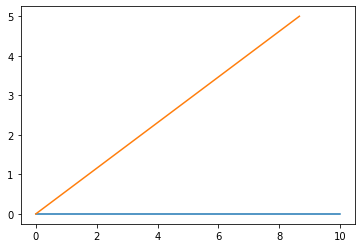

In [103]:
def get_rota_mat(a):
    ''' 
    返回左乘的旋转矩阵,a是逆时针旋转的弧度
    '''
    rota_mat = np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    return rota_mat

def rotate_points(arr,a):
    ''' 
    把arr逆时针旋转a弧度
    arr是[n*2]的形状
    返回的结果也是n*2的结果
    '''
    rm = get_rota_mat(a)
    arr2 = np.dot(arr,rm.T)
    return arr2

x = np.linspace(0,10,100)
y = np.linspace(0,0,100)
z = np.array([x,y]).T
y2 = rotate_points(z,np.pi/6)
plt.plot(x,y,y2[:,0],y2[:,1])

In [152]:
# 抽第120帧作为参考点
frame_id = 120
n_hist_frames = 30
neig_ids = fusion_10hz_df[fusion_10hz_df.frame_id==frame_id].obj_id
print(neig_ids.to_numpy())
# ref_pos = fusion_10hz_df[(fusion_10hz_df.frame_id==frame_id) & (fusion_10hz_df.obj_id==obj_id)].iloc[0].loc[['GlobalX','GlobalY']].to_numpy()
ref_pos = 0
# print(ref_pos)
neig_hist = []
start_frame = frame_id-n_hist_frames
print(f"The start frame: {start_frame}")

orie_w = 0
for neig_id in neig_ids:
    neig_df = fusion_10hz_df[(fusion_10hz_df.obj_id==neig_id)]
    neig_frame_df = neig_df[(neig_df.frame_id>=start_frame) & (neig_df.frame_id<=frame_id)]
    if (neig_id==0):
        orie_w = neig_frame_df['oritentation_yaw'].mean()
        ref_pos = neig_frame_df.iloc[-1].loc[['GlobalX','GlobalY']].to_numpy()
        print(f"orie_w:{orie_w}")
    if neig_df.frame_id.iloc[0] > start_frame:
        # print(neig_id)
        # print(neig_df.frame_id.iloc[0])
        # neig_hist.append(np.empty([0,2]))
        continue
    hist = neig_frame_df.loc[:,['GlobalX','GlobalY']].to_numpy(np.float32) - ref_pos
    hist = np.array(hist, dtype=np.float32)
    neig_hist.append(hist)
    # print(neig_id)
    # print(hist.shape)
    # print(hist)
    
# neig_hist[0][:]
neig_hist2 = []
for i in neig_hist:
    ret = rotate_points(i,-orie_w)
    # ret = i
    neig_hist2.append(ret)
# print(ref_pos)
# rot_neig_hist = []
# for i in neig_hist:
#     j = i-ref_pos
#     rot_neig_hist.append(j)
    
# rot_neig_hist2 = []
# ref_pos2 = neig_hist2[0][0,:]
# print(ref_pos2)
# for i in neig_hist2:
#     j = i-ref_pos2
#     rot_neig_hist2.append(j)
    

[ 0  4  6  8 10 22]
The start frame: 90
orie_w:-0.09141983870967742


In [153]:
# l1 = neig_hist[0]
# l2 = rotate_points(l1,-orie_w)
# # fig, ax = plt.subplots(dpi=300)
# plt.axis('equal')
# plt.plot(l1[:,0],l1[:,1],l2[:,0],l2[:,1])
# print(l1[0,:],l2[0,:])
# print(l1[0,0]**2 + l1[0,1]**2)
# print(l2[0,0]**2 + l2[0,1]**2)

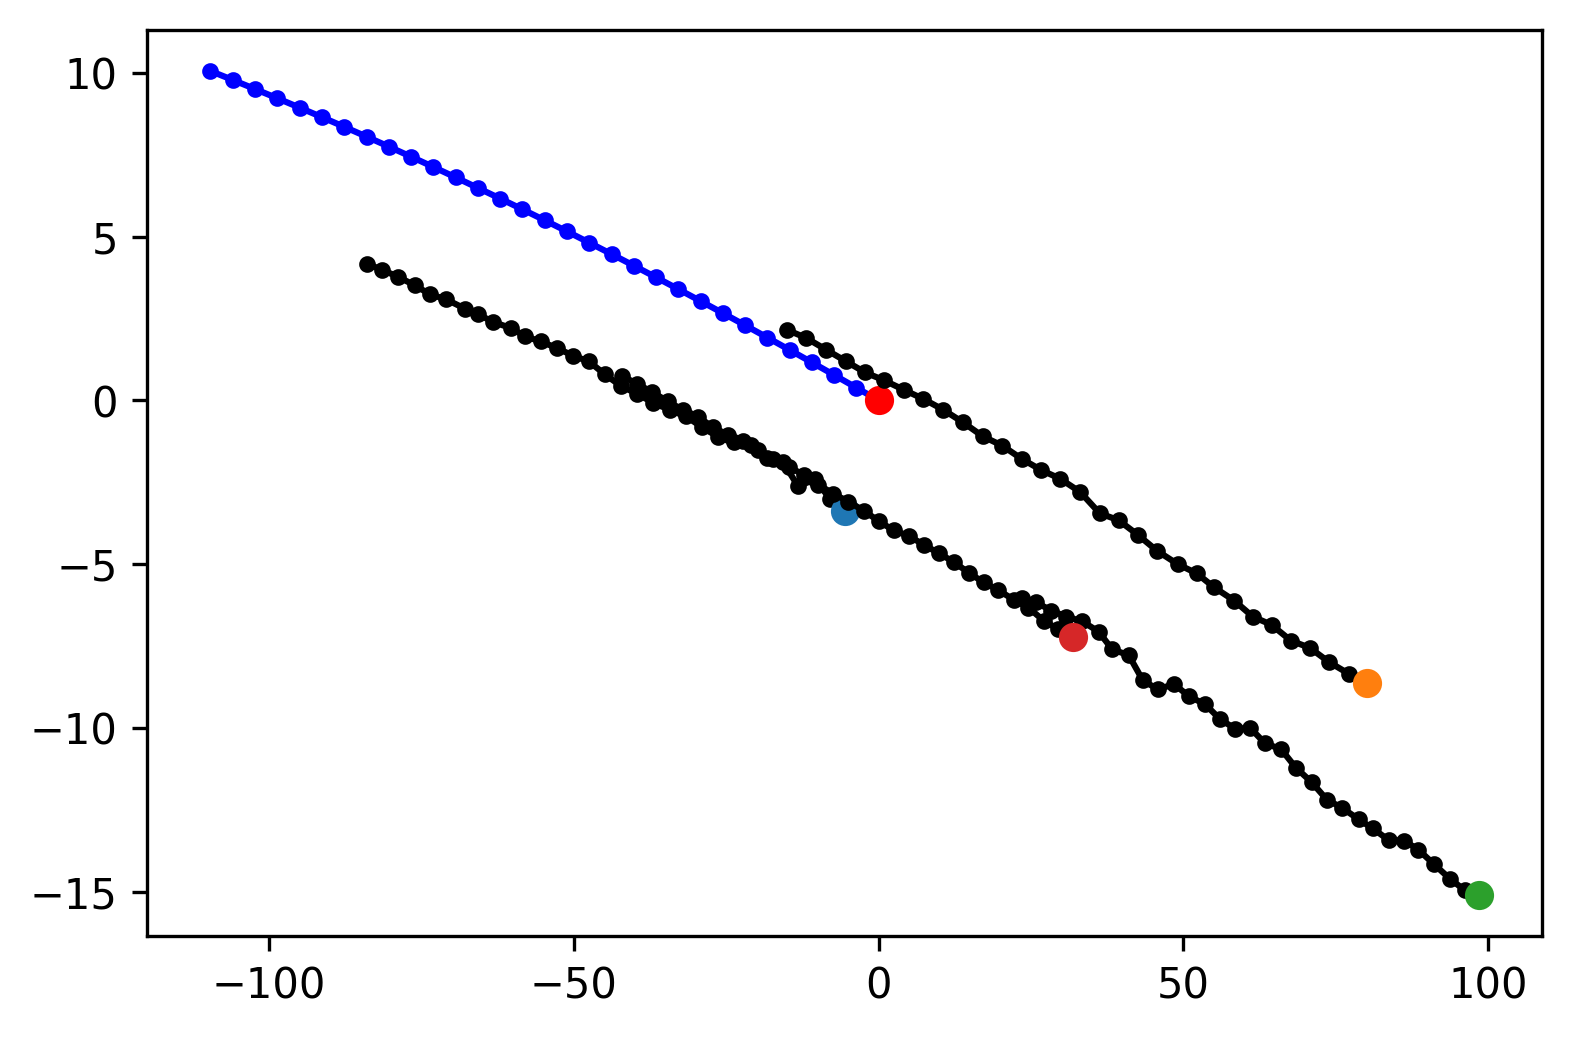

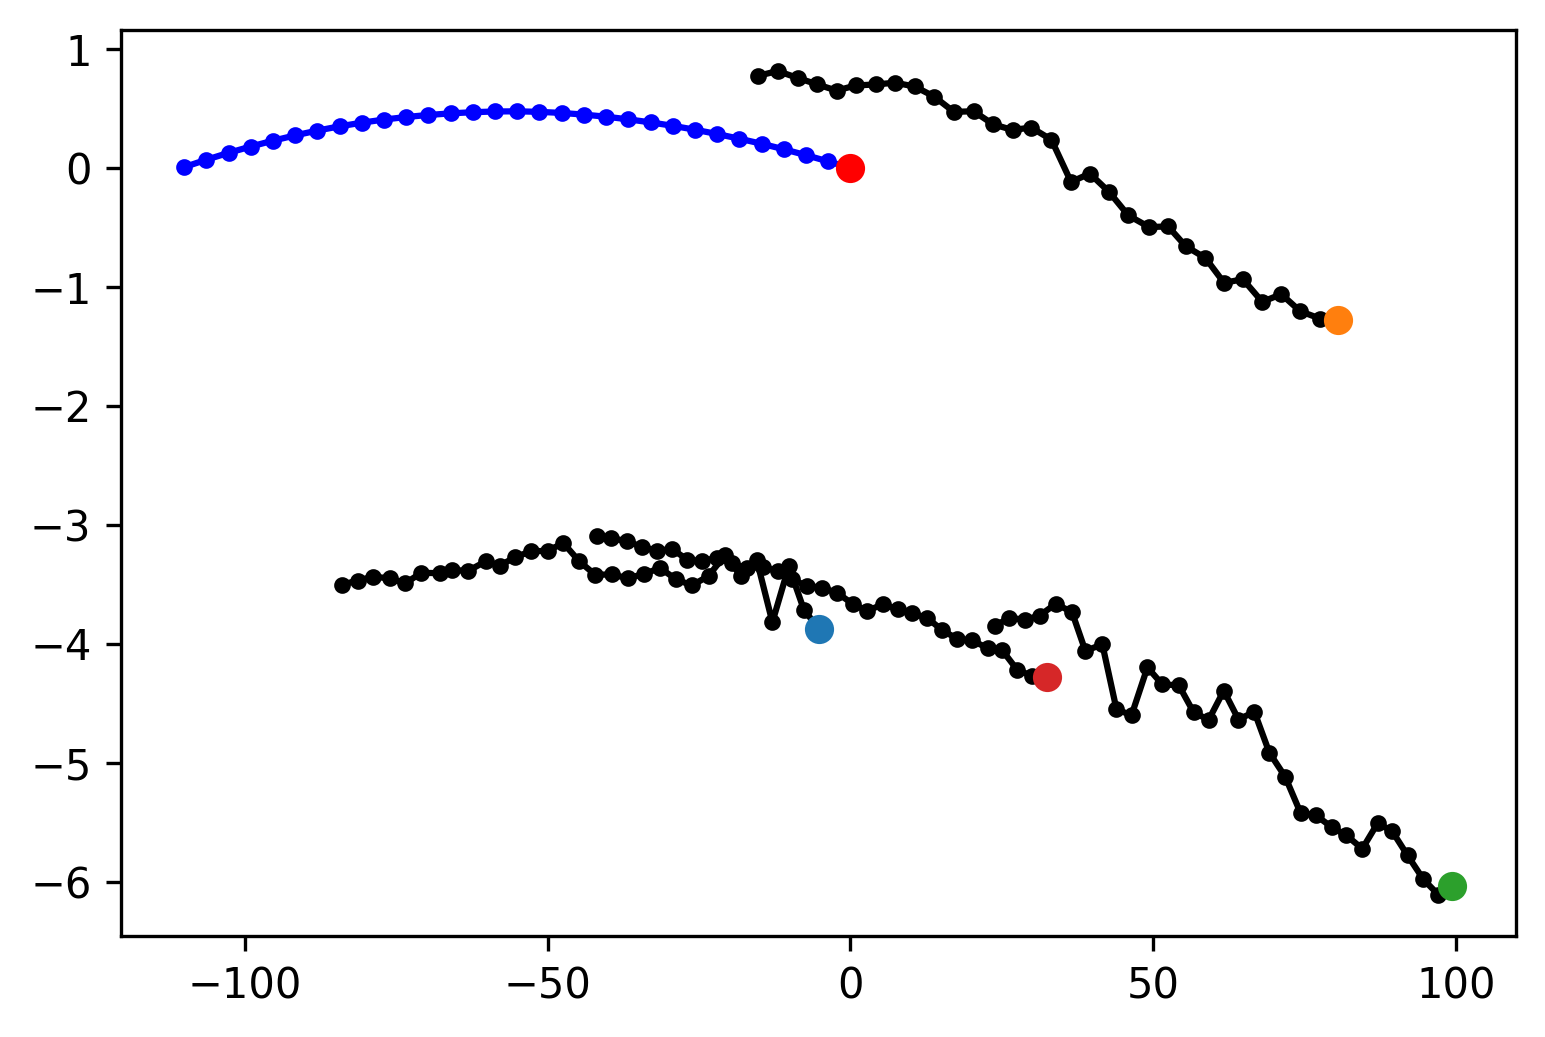

In [154]:
def ld_data_hist_plot(hist):
    fig, ax = plt.subplots(dpi=300)
    # plt.axis('equal')
    for i in range(len(hist)):
        if i == 0:
            ax.plot(hist[i][:, 0], hist[i][:, 1], 'b', label='target_hist')
            ax.plot(hist[i][:, 0], hist[i][:, 1], '.b')
            ax.plot(hist[i][-1, 0], hist[i][-1, 1], 'or')
        else:
            ax.plot(hist[i][:, 0], hist[i][:, 1], 'k')
            ax.plot(hist[i][:, 0], hist[i][:, 1], '.k')
            ax.plot(hist[i][-1, 0], hist[i][-1, 1], 'o')
    plt.show()
ld_data_hist_plot(neig_hist)
ld_data_hist_plot(neig_hist2)

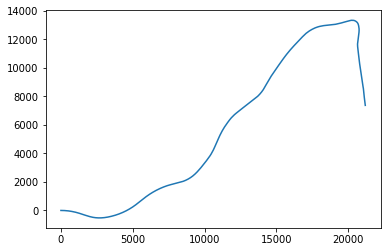

In [108]:
ego_csv = "/home/jiang/trajectory_pred/ld_dataset/Dataset_for_Master_Thesis/LIDAR_LJ02766_20210915_101959_G260-PDX-006-001-052_000000-000060_LD_final_OD_MERGE_OPP/LIDAR_LJ02766_20210915_101959_G260-PDX-006-001-052_000000-000060_LD_final_OD_MERGE_OPP_ego.csv"
ego_df = pd.read_csv(ego_csv)
x = ego_df['position x'].to_numpy()
y = ego_df['position y'].to_numpy()
plt.plot(x,y)
plt.show()

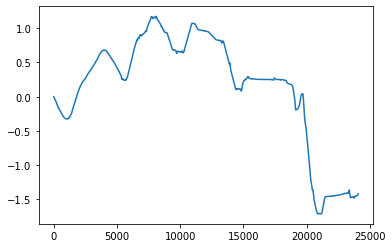

In [109]:
orie_w = ego_df['oritentation yaw'].to_numpy()
orie_w_diff = orie_w[1:]-orie_w[:-1]
plt.plot(orie_w)
plt.show()

157
747


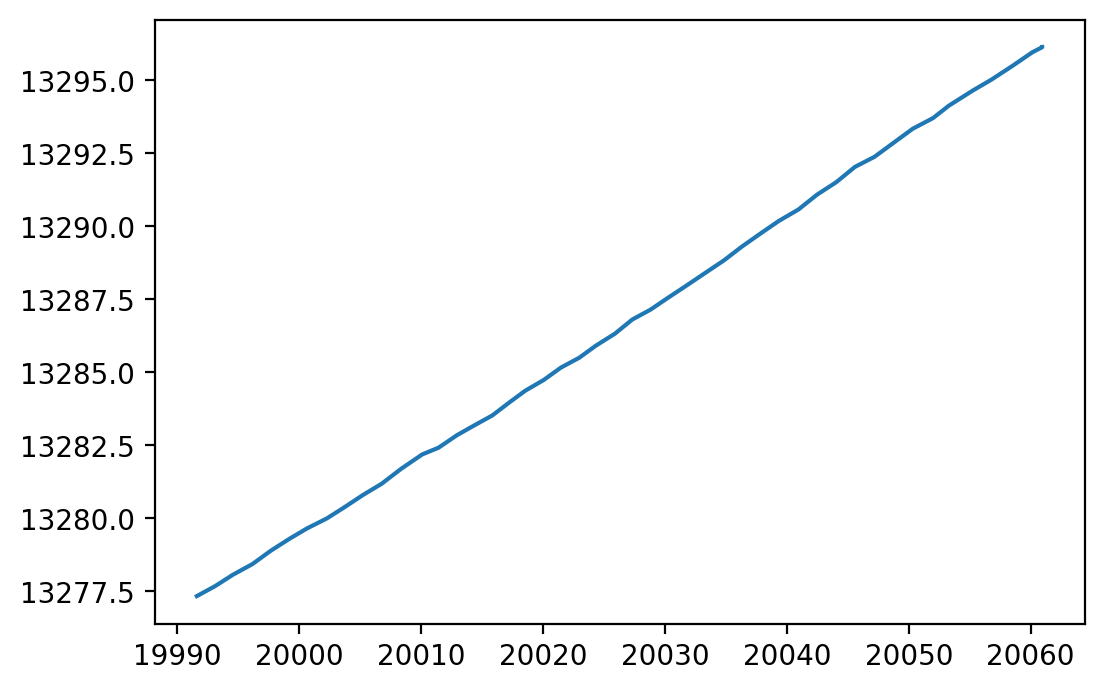

In [150]:
import random
plot_df = fusion_10hz_df[fusion_10hz_df.frame_id<=30000]
plot_id = plot_df.obj_id.unique()
print(len(plot_id))
fig, ax = plt.subplots(dpi=200)
i = random.choice(plot_id)
# i = 132
print(i)
id_df = plot_df[plot_df.obj_id==i]
x = id_df.GlobalX.to_numpy()
y = id_df.GlobalY.to_numpy()
ax.plot(x,y)

# fig, ax = plt.subplots(dpi=300)
# for i in plot_id:
#     id_df = plot_df[plot_df.obj_id==i]
#     x = id_df.GlobalX.to_numpy()
#     y = id_df.GlobalY.to_numpy()
#     z = np.array([x,y]).
#     ax.plot(x,y)